In [1]:
import os
import sys
dir_path = os.getcwd()
print("The directory of this script is:", dir_path)
root_path = os.path.dirname(dir_path)
sys.path.append(root_path)
print("The root directory is:", root_path)

The directory of this script is: c:\Users\HP\Desktop\Projects\Subscription-Churn-Prediction\notebooks
The root directory is: c:\Users\HP\Desktop\Projects\Subscription-Churn-Prediction


In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv(f"{root_path}\data\Telco-Customer-Churn.csv")
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="coerce").fillna(0).astype(float)
data['gender'] = data['gender'].map({'Male': 1, 'Female': 0})
data['Contract'] = data['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})

n_bins = 5
for col in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    bins, bin_edges = pd.qcut(data[col], q=n_bins, retbins=True, duplicates='drop')
    print(f"{col} bin edges (right): {bin_edges[1:]}")
    data[f'{col}_bin'] = bins.cat.codes.astype(int)
for col in data.columns:
    if col == 'Churn':
        continue
    unique_vals = data[col].dropna().unique()
    if set(unique_vals) <= {'Yes', 'No'}:
        data[col] = data[col].map({'No': 0, 'Yes': 1})

for col in data.columns:
    if col == 'Churn':
        continue
    unique_vals = data[col].dropna().unique()
    if 'No phone service' in unique_vals or 'No internet service' in unique_vals:
        mapping = {'No phone service': -1, 'No internet service': -1, 'No': 0, 'Yes': 1}
        data[col] = data[col].map(mapping)

data

tenure bin edges (right): [ 6. 20. 40. 60. 72.]
MonthlyCharges bin edges (right): [ 25.05  58.83  79.1   94.25 118.75]
TotalCharges bin edges (right): [ 265.32  939.78 2043.71 4471.44 8684.8 ]


customerID  gender  SeniorCitizen  Partner  Dependents  tenure  \
0     7590-VHVEG       0              0        1           0       1   
1     5575-GNVDE       1              0        0           0      34   
2     3668-QPYBK       1              0        0           0       2   
3     7795-CFOCW       1              0        0           0      45   
4     9237-HQITU       0              0        0           0       2   
...          ...     ...            ...      ...         ...     ...   
7038  6840-RESVB       1              0        1           1      24   
7039  2234-XADUH       0              0        1           1      72   
7040  4801-JZAZL       0              0        1           1      11   
7041  8361-LTMKD       1              1        1           0       4   
7042  3186-AJIEK       1              0        0           0      66   

      PhoneService  MultipleLines InternetService  OnlineSecurity  ...  \
0                0             -1             DSL               0  ...   
1                1              0             DSL               1  ...   
2                1              0             DSL               1  ...   
3                0             -1             DSL               1  ...   
4                1              0     Fiber optic               0  ...   
...            ...            ...             ...             ...  ...   
7038             1              1             DSL               1  ...   
7039             1              1     Fiber optic               0  ...   
7040             0             -1             DSL               1  ...   
7041             1              1     Fiber optic               0  ...   
7042             1              0     Fiber optic               1  ...   

      StreamingMovies  Contract  PaperlessBilling              PaymentMethod  \
0                   0         0                 1           Electronic check   
1                   0         1                 0               Mailed check   
2                   0         0                 1               Mailed check   
3                   0         1                 0  Bank transfer (automatic)   
4                   0         0                 1           Electronic check   
...               ...       ...               ...                        ...   
7038                1         1                 1               Mailed check   
7039                1         1                 1    Credit card (automatic)   
7040                0         0                 1           Electronic check   
7041                0         0                 1               Mailed check   
7042                1         2                 1  Bank transfer (automatic)   

      MonthlyCharges  TotalCharges  Churn tenure_bin  MonthlyCharges_bin  \
0              29.85         29.85     No          0                   1   
1              56.95       1889.50     No          2                   1   
2              53.85        108.15    Yes          0                   1   
3              42.30       1840.75     No          3                   1   
4              70.70        151.65    Yes          0                   2   
...              ...           ...    ...        ...                 ...   
7038           84.80       1990.50     No          2                   3   
7039          103.20       7362.90     No          4                   4   
7040           29.60        346.45     No          1                   1   
7041           74.40        306.60    Yes          0                   2   
7042          105.65       6844.50     No          4                   4   

      TotalCharges_bin  
0                    0  
1                    2  
2                    0  
3                    2  
4                    0  
...                ...  
7038                 2  
7039                 4  
7040                 1  
7041                 1  
7042                 4  

[7043 rows x 24 columns]

In [3]:
for col in data.columns:
    if col == "customerID":
        continue
    print(data[col].value_counts(dropna=False, normalize=True))
    print("-"*40)

gender
1    0.504756
0    0.495244
Name: proportion, dtype: float64
----------------------------------------
SeniorCitizen
0    0.837853
1    0.162147
Name: proportion, dtype: float64
----------------------------------------
Partner
0    0.516967
1    0.483033
Name: proportion, dtype: float64
----------------------------------------
Dependents
0    0.700412
1    0.299588
Name: proportion, dtype: float64
----------------------------------------
tenure
1     0.087037
72    0.051399
2     0.033792
3     0.028397
4     0.024989
        ...   
28    0.008093
39    0.007951
44    0.007241
36    0.007099
0     0.001562
Name: proportion, Length: 73, dtype: float64
----------------------------------------
PhoneService
1    0.903166
0    0.096834
Name: proportion, dtype: float64
----------------------------------------
MultipleLines
 0    0.481329
 1    0.421837
-1    0.096834
Name: proportion, dtype: float64
----------------------------------------
InternetService
Fiber optic    0.439585
DSL   

In [4]:
from sklearn.model_selection import train_test_split
X = data.drop(["Churn","customerID", 'tenure', 'MonthlyCharges', 'TotalCharges'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = data["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [5]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score


class_weight={ 'No': 1, 'Yes': 5 }
clf = DecisionTreeClassifier(splitter="best" , max_depth=10, criterion='gini',min_samples_split=80, min_samples_leaf=20, class_weight=class_weight)
clf.fit(X_train, y_train)
for name, features_set, labels_set in [('Train', X_train, y_train), ('Test', X_test, y_test)]:
    print("-"*40)
    y_predicted = clf.predict(features_set)
    acc = accuracy_score(labels_set, y_predicted)
    prec = precision_score(labels_set, y_predicted, pos_label="Yes")
    rec = recall_score(labels_set, y_predicted, pos_label="Yes")
    fbeta = fbeta_score(labels_set, y_predicted, beta=2, pos_label="Yes")
    print(f"{name} - Accuracy: {acc:.4f} - Precision: {prec:.4f} - Recall: {rec:.4f} - F2: {fbeta:.4f}")

print("-"*40)
print("Tree depth:", clf.get_depth())
print("Number of leaves:", clf.get_n_leaves())
print("Total nodes:", clf.tree_.node_count)

----------------------------------------
Train - Accuracy: 0.6997 - Precision: 0.4664 - Recall: 0.9137 - F2: 0.7666
----------------------------------------
Test - Accuracy: 0.6977 - Precision: 0.4631 - Recall: 0.8717 - F2: 0.7409
----------------------------------------
Tree depth: 10
Number of leaves: 101
Total nodes: 201


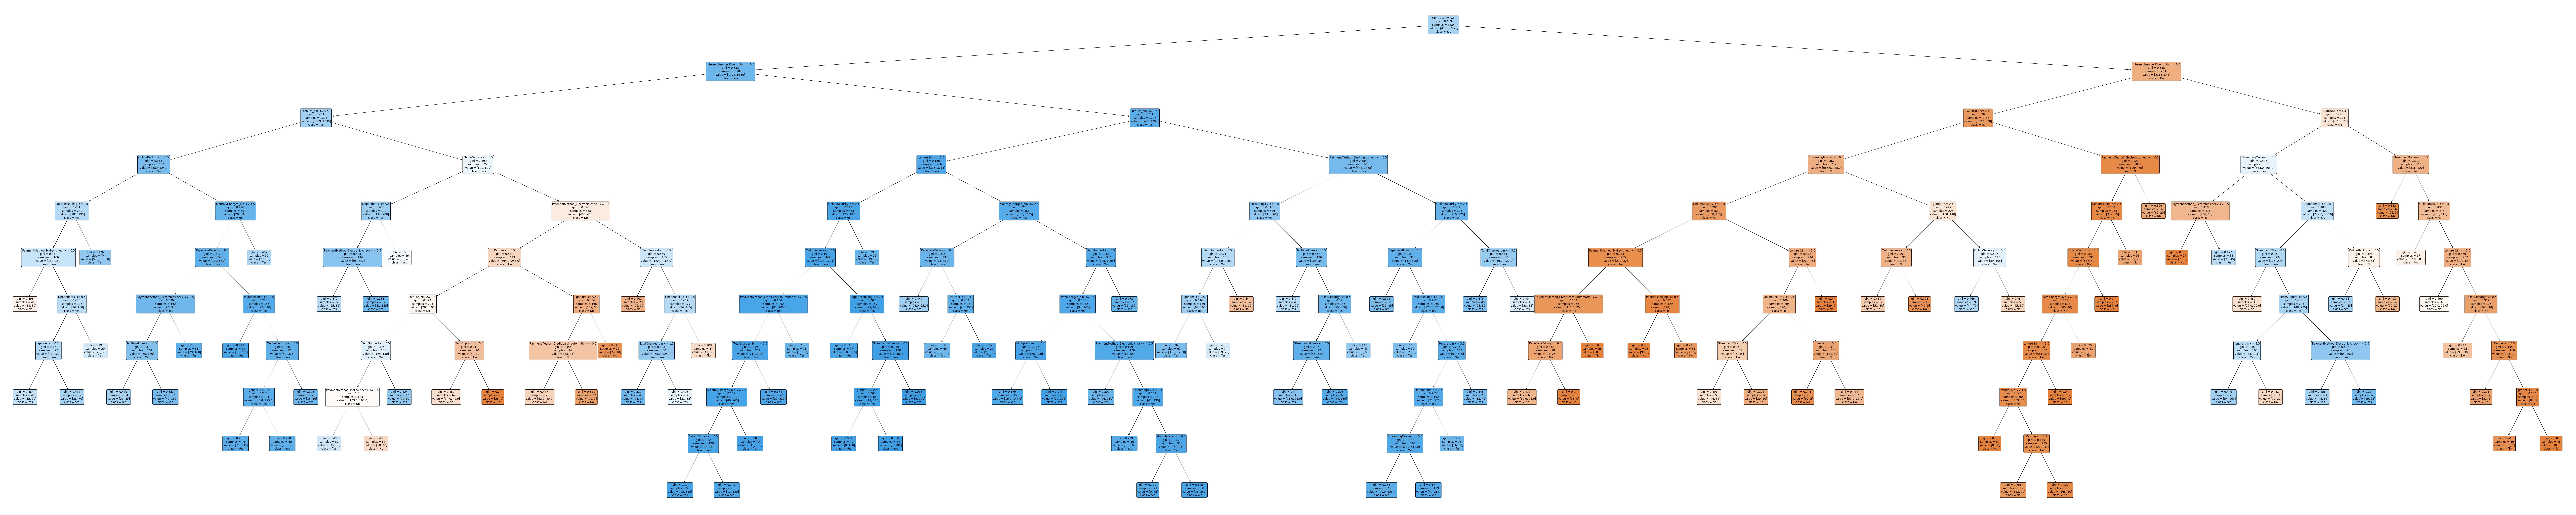

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(200,40))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=[str(c) for c in clf.classes_],
    filled=True,
    rounded=True,
    fontsize=12
)
plt.savefig("output/churn_tree_plot.png")
plt.show()

In [7]:
import pickle
with open("output/churn_tree_model.pkl", "wb") as f:
    pickle.dump(clf, f)

In [8]:
import shap
print(clf.classes_)
explainer = shap.TreeExplainer(clf)
shap_vals = explainer.shap_values(X_train)
print(shap_vals.shape)
shap_use = shap_vals[:, :, 1]

mean_abs = np.abs(shap_use).mean(axis=0)
df_shap = pd.Series(mean_abs, index=X_train.columns).sort_values(ascending=False)
print(df_shap)

['No' 'Yes']
(5634, 22, 2)
Contract                                 0.201259
InternetService_Fiber optic              0.103357
tenure_bin                               0.066465
PaymentMethod_Electronic check           0.033682
StreamingMovies                          0.031262
OnlineSecurity                           0.018436
OnlineBackup                             0.016958
PhoneService                             0.012796
PaperlessBilling                         0.010151
TechSupport                              0.009447
MultipleLines                            0.008674
MonthlyCharges_bin                       0.008633
StreamingTV                              0.008591
Partner                                  0.008371
gender                                   0.007964
Dependents                               0.006675
TotalCharges_bin                         0.006363
PaymentMethod_Credit card (automatic)    0.004213
PaymentMethod_Mailed check               0.003147
SeniorCitizen          

In [ ]:
shap.summary_plot(shap_use, X_train, plot_size=[12,8])

<Figure size 640x480 with 0 Axes>

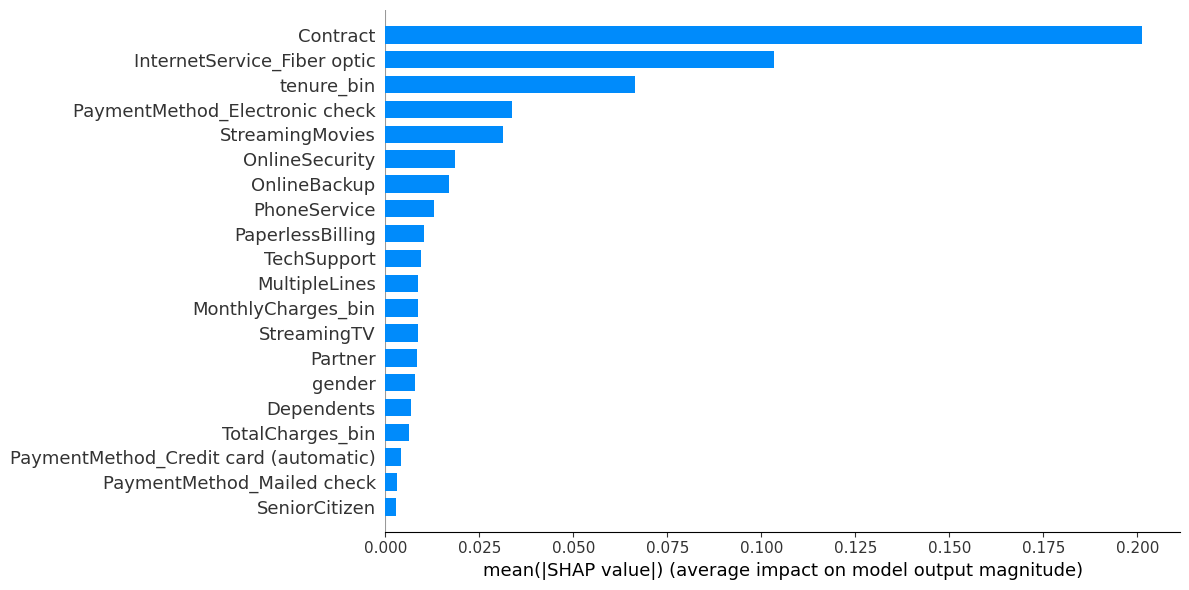

In [10]:
plt.figure(figsize=(16, 8))
shap_plot_bar = shap.summary_plot(shap_use, X_train, plot_type="bar", plot_size=[12,6])

In [11]:
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance

f2_scorer = make_scorer(fbeta_score, beta=2, pos_label="Yes")

result = permutation_importance(
    clf,
    X_test,
    y_test,
    n_repeats=50,
    random_state=42,
    scoring=f2_scorer
)

perm_importances = pd.Series(result.importances_mean, index=X_test.columns)
perm_importances = perm_importances.sort_values(ascending=False)
print(perm_importances)


Contract                                 0.191991
InternetService_Fiber optic              0.053960
tenure_bin                               0.047159
PhoneService                             0.013313
OnlineBackup                             0.007135
PaymentMethod_Mailed check               0.006515
TechSupport                              0.005534
StreamingTV                              0.005350
PaymentMethod_Electronic check           0.002804
PaperlessBilling                         0.002593
Partner                                  0.002223
OnlineSecurity                           0.001798
DeviceProtection                         0.000000
PaymentMethod_Credit card (automatic)    0.000000
SeniorCitizen                            0.000000
MultipleLines                            0.000000
MonthlyCharges_bin                       0.000000
TotalCharges_bin                         0.000000
InternetService_No                       0.000000
gender                                  -0.001072


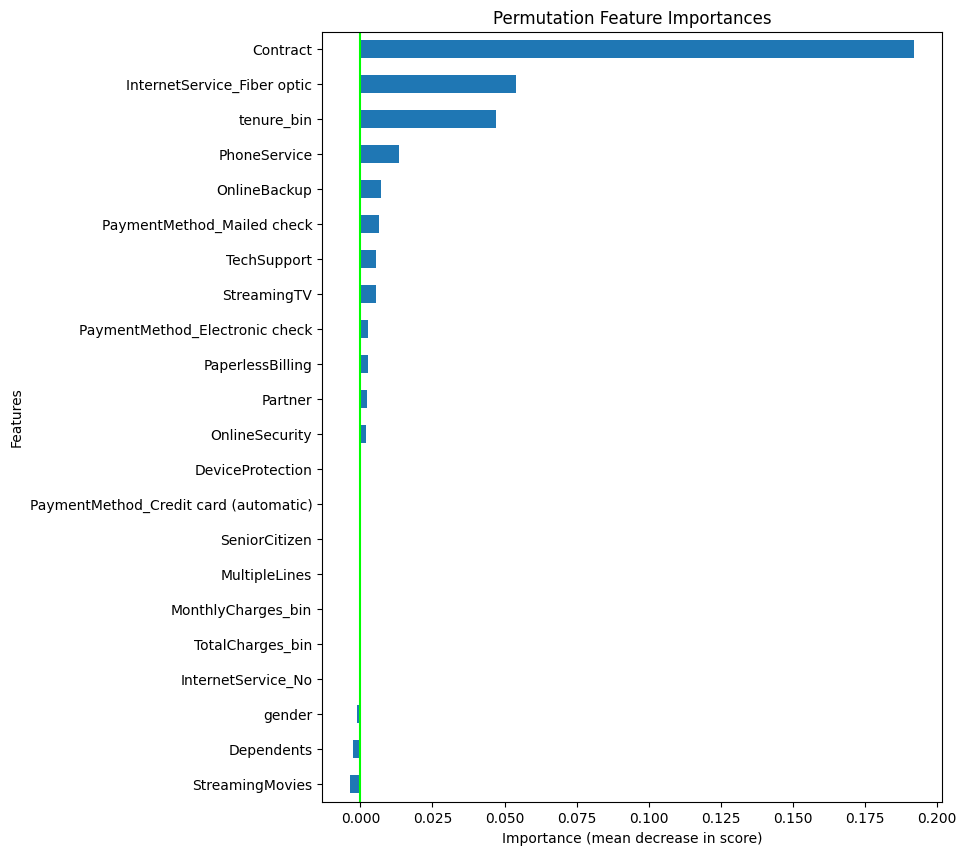

In [12]:
plt.figure(figsize=(8,10))  # swap width and height for better layout
perm_importances.plot(kind='barh')
plt.title("Permutation Feature Importances")
plt.xlabel("Importance (mean decrease in score)")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.axvline(0, color='lime', linestyle='-')
plt.show()
